## Capstone Project - The Battle of Neighborhoods 


### Search for Similar City Neighborhoods for NY Graduating Students Using Nearby Venues of Given City Locations

### Import Python libraries and tools for data analysis

In [1]:

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # import geocoder

import requests # library to handle requests
import lxml.html as lh
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
from urllib.request import urlopen

import math 
import numpy as np 
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Data Collection

Here we used a list of 200 US largest cities in terms of population from http://worldpopulationreview.com/us-cities/

In [ ]:
# Data source one:   http://worldpopulationreview.com/us-cities/

In [27]:
#Create a handle, page, to handle the contents of the website
url = 'http://worldpopulationreview.com/us-cities/#cities'
page = requests.get(url)#Store the contents of the website under doc
doc = lh.fromstring(page.content)#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [28]:
# Let us parse the first row of the table as our header.
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=str(t.text_content())
    print (i,',',name)
    # The name will be used as data frame column. The trailing whitespace must be removed
    col.append((name.strip(),[]))

1 , Rank  
2 , Name  
3 , State  
4 , 2020 Population  
5 , 2010 Census  
6 , Change  
7 , 2020 Density  
8 , Latitude/Longitude  
9 , Area (km²)  


In [29]:
#Since the first row is the header, data is stored on the second row onwards
len_col = len(col)
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row does not have right size, the //tr data is not from our table 
    if len(T)!=len_col :
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=str(t.text_content())
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [30]:
# Create a data frame 
Dict={title:column for (title,column) in col}
raw_data_df = pd.DataFrame(Dict)

print(raw_data_df.dtypes)
print('\n Here is the table read from the http://worldpopulationreview.com/us-cities:')
raw_data_df.head()

Rank                  object
Name                  object
State                 object
2020 Population       object
2010 Census           object
Change                object
2020 Density          object
Latitude/Longitude    object
Area (km²)            object
dtype: object

 Here is the table read from the http://worldpopulationreview.com/us-cities:


,Rank,Name,State,2020 Population,2010 Census,Change,2020 Density,Latitude/Longitude,Area (km²)
0,1,New York,New York,"8,622,357","8,175,133",0.25%,"11,084/km²",40.66/-73.94,778
1,2,Los Angeles,California,"4,085,014","3,792,621",0.67%,"3,365/km²",34.02/-118.41,"1,214"
2,3,Chicago,Illinois,"2,670,406","2,695,598",-0.32%,"4,535/km²",41.84/-87.68,589
3,4,Houston,Texas,"2,378,146","2,099,451",0.79%,"1,443/km²",29.79/-95.39,"1,649"
4,5,Phoenix,Arizona,"1,743,469","1,445,632",1.88%,"1,300/km²",33.57/-112.09,"1,341"


In [57]:
# Clean up the raw data
# Keep only population change, population density, lat/long
raw_data_df2 = raw_data_df.drop(['Rank', 'State','2020 Population','2010 Census','Change','Area (km²)'], axis =1)

raw_data_df2['2020 Density'] = raw_data_df2['2020 Density'].str.strip('/km²')
#raw_data_df2['2020 Density'] = raw_data_df2['2020 Density'].str.strip(',').astype(int64)


# Extract coordinates
raw_data_df2[['Latitude','Longitude']] = raw_data_df2['Latitude/Longitude'].str.split("\/",expand=True,)
raw_data_df2.drop(['Latitude/Longitude'], axis=1, inplace=True)

# Convert data types
raw_data_df2["Latitude"] = pd.to_numeric(raw_data_df2["Latitude"])
raw_data_df2["Longitude"] = pd.to_numeric(raw_data_df2["Longitude"])
raw_data_df2["2020 Density"] = raw_data_df2["2020 Density"].str.replace(',','').astype(float)
raw_data_df2.rename(columns = {'Name':'City'}, inplace = True)

print('Check we have the right data types now\n')
print(raw_data_df2.dtypes)

Check we have the right data types now

City             object
2020 Density    float64
Latitude        float64
Longitude       float64
dtype: object


In [ ]:
# Save this data frame 
raw_data_df2.to_csv(r'C:\MyLearning\Coursera\IBM_datasci_certificate\applied_dataci_capstone\projects\Coursera_Capstone\us200cities_reduced_data.csv')
raw_data_df2.head()

In [2]:
# Option to read the data that was from the previous step
raw_data_df2 = pd.read_csv('C:/MyLearning/Coursera/IBM_datasci_certificate/applied_dataci_capstone/projects/Coursera_Capstone/us200cities_reduced_data.csv')

In [3]:
# Check the data size
raw_data_df2.shape

(200, 5)

In [4]:
# View the selected cities by creating a map using latitude and longitude values

# Use approximate geographical center of the USA to center the map
latitude_ctr = 39.387436
longitude_ctr = -94.290265
map_cities= folium.Map(location=[latitude_ctr, longitude_ctr], zoom_start=4)

# add markers to map
for city, lat, lng in zip(raw_data_df2['City'], raw_data_df2['Latitude'], raw_data_df2['Longitude']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities)  
    
map_cities

Our second data source is from Four Square for city venues. We will use explore function to find nearby venues of given coordinates

In [4]:
# Data source two:  Prepare for data query from Four Square
CLIENT_ID = 'CMFI1RYFZCDLAVJARX1K2FKK1Q3L4E0ZM3A5OYJSTT51S4IP' # your Foursquare ID
CLIENT_SECRET = 'N5HAJXJ4YB5G02E2QHDSEAF4AQBGOCDTKSWW0AG5GYZHZMS2' # your Foursquare Secret
VERSION = '20190515' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 1000
LIMIT = 100

Your credentails:
CLIENT_ID: CMFI1RYFZCDLAVJARX1K2FKK1Q3L4E0ZM3A5OYJSTT51S4IP
CLIENT_SECRET:N5HAJXJ4YB5G02E2QHDSEAF4AQBGOCDTKSWW0AG5GYZHZMS2


In [5]:
# Define a function to explore nearby venues for given coordinates
def getNearbyVenues( names,  latitudes, longitudes, radius=1000):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL and explore the coordinates centered area
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
             # return only relevant information for each nearby venue
            venues_list.append([(name, lat, lng,  v['venue']['name'], 
                  v['venue']['location']['lat'], 
                  v['venue']['location']['lng'], 
                  v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['City',
                'City Latitude', 
                'City Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude',
                'Venue Category']
        except:
            continue
            print('Insufficient venue data for ', name)
    
    return(nearby_venues)

In [8]:
# Test data query
lat = 40.66
lng = -73.94
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']

In [7]:
# Get nearby venues for given coordinates
nearby_venues = getNearbyVenues( names = raw_data_df2['City'],
                               latitudes=raw_data_df2['Latitude'],
                              longitudes=raw_data_df2['Longitude'])

In [10]:
# Check the nearby venues data frame 
print(nearby_venues.shape)
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))
nearby_venues.to_csv(r'C:\MyLearning\Coursera\IBM_datasci_certificate\applied_dataci_capstone\projects\Coursera_Capstone\us200cities_nearby_venues.csv')

# Check the nearby venue data frame
nearby_venues.head()

(12981, 7)
There are 434 uniques categories.


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.789624,-73.959894,North Meadow,40.792027,-73.959853,Park
1,New York,40.789624,-73.959894,Central Park Tennis Center,40.789313,-73.961862,Tennis Court
2,New York,40.789624,-73.959894,East Meadow,40.790160,-73.955498,Field
3,New York,40.789624,-73.959894,Central Park - Woodman's Gate,40.787786,-73.955924,Park
4,New York,40.789624,-73.959894,The Jewish Museum,40.785276,-73.957411,Museum


In [5]:
# Option to read the venue data saved from the previous step
nearby_venues = pd.read_csv('C:/MyLearning/Coursera/IBM_datasci_certificate/applied_dataci_capstone/projects/Coursera_Capstone/us200cities_nearby_venues.csv')

### Data Preparation

In [3]:
# Check the city list again
city_list = nearby_venues['City']
type(city_list)

pandas.core.series.Series

In [4]:
# Check New York data
dd = nearby_venues.loc[nearby_venues['City'].isin(['New York'])]
dd.head()

,Unnamed: 0,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,New York,40.789624,-73.959894,North Meadow,40.792027,-73.959853,Park
1,1,New York,40.789624,-73.959894,Central Park Tennis Center,40.789313,-73.961862,Tennis Court
2,2,New York,40.789624,-73.959894,East Meadow,40.790160,-73.955498,Field
3,3,New York,40.789624,-73.959894,Central Park - Woodman's Gate,40.787786,-73.955924,Park
4,4,New York,40.789624,-73.959894,The Jewish Museum,40.785276,-73.957411,Museum


In [6]:
nearby_venues.head()

,Unnamed: 0,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,New York,40.789624,-73.959894,North Meadow,40.792027,-73.959853,Park
1,1,New York,40.789624,-73.959894,Central Park Tennis Center,40.789313,-73.961862,Tennis Court
2,2,New York,40.789624,-73.959894,East Meadow,40.790160,-73.955498,Field
3,3,New York,40.789624,-73.959894,Central Park - Woodman's Gate,40.787786,-73.955924,Park
4,4,New York,40.789624,-73.959894,The Jewish Museum,40.785276,-73.957411,Museum


In [7]:
# We will use normalized numbers of nearby venues in avaiable venue categories as features for city clustering
# Create one hot encoding for venue categories
city_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['City'] = nearby_venues['City'] 


# move city column from the last to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

print(city_onehot.shape)

city_onehot.groupby('City').sum()

(12981, 435)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
# Check city area mean values: number of venues in each category divided by total venues 
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Rec Center,College Residence Hall,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New 

In [9]:
# Add population density to the data frame <city_grouped> as additional feature
city_grouped['Population Density'] = raw_data_df2['2020 Density']/1000000

In [10]:
city_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Rec Center,College Residence Hall,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New 

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
# Check 10 top common venues for each city
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

print(city_venues_sorted.shape)    
city_venues_sorted.head()


(191, 11)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akron,Sandwich Place,Bar,Bank,Coffee Shop,Italian Restaurant,Music Venue,Café,Performing Arts Venue,Mexican Restaurant,Gay Bar
1,Albuquerque,Brewery,Sandwich Place,Mexican Restaurant,Gas Station,Gym,Gourmet Shop,Bistro,Sushi Restaurant,American Restaurant,Breakfast Spot
2,Alexandria,Rental Car Location,Gym,Park,Flower Shop,Gas Station,Population Density,Indian Restaurant,Field,Event Space,Exhibit
3,Amarillo,Sushi Restaurant,Mexican Restaurant,Hockey Arena,Convenience Store,Performing Arts Venue,Nightclub,Hotel,Grocery Store,Farmers Market,Discount Store
4,Anaheim,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Convenience Store,Flower Shop,Pet Store,Liquor Store,Intersection,Ice Cream Shop,Home Service


In [32]:
# We have 191 cities only, since some cities don't sufficient data when reading from Four Square

### Clustering - K-means

In [13]:
# Use Silhouette to select the number of clusters
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
city_grouped_clustering = city_grouped.drop('City', 1)
for n_clusters in range_n_clusters:
    
    # Run k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit_predict(city_grouped_clustering)
    silhouette_avg = silhouette_score(city_grouped_clustering, kmeans)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.34307027482809443
For n_clusters = 3 The average silhouette_score is : 0.13991281940143002
For n_clusters = 4 The average silhouette_score is : 0.013366822135785652
For n_clusters = 5 The average silhouette_score is : 0.035338420483921634
For n_clusters = 6 The average silhouette_score is : 0.030473741937531978
For n_clusters = 7 The average silhouette_score is : 0.017679081113097343
For n_clusters = 8 The average silhouette_score is : 0.05312298942495712
For n_clusters = 9 The average silhouette_score is : 0.02762363159400471
For n_clusters = 10 The average silhouette_score is : 0.03435195879638507
For n_clusters = 11 The average silhouette_score is : 0.03269676358472456
For n_clusters = 12 The average silhouette_score is : 0.020868266693060404
For n_clusters = 13 The average silhouette_score is : 0.03111562159027115
For n_clusters = 14 The average silhouette_score is : -0.0497441982235454
For n_clusters = 15 The average silhouett

In [14]:
# Calculate feature matrix for Dendrogram
from sklearn.preprocessing import MinMaxScaler
x = city_grouped_clustering.values #returns a numpy array
feature_mtx = x

C:\Users\Dexin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


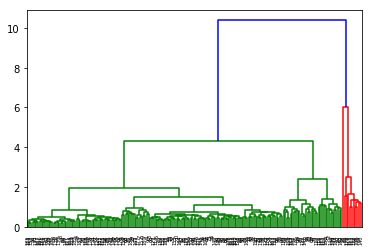

In [15]:
# Check Dendrogram
dist_matrix = distance_matrix(feature_mtx, feature_mtx) 
Z = hierarchy.linkage(dist_matrix, 'complete')
dendro = hierarchy.dendrogram(Z)

In [16]:
# To have reasonable granularity, let us 8 clusters
kclusters = 8

In [17]:
# Use the k with higher silhouette_score, here is the clustered labels for each city
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(city_grouped_clustering)
kmeans.labels_

array([5, 5, 1, 5, 7, 5, 5, 7, 5, 7, 5, 5, 1, 7, 1, 1, 7, 5, 5, 3, 3, 7,
       5, 5, 5, 5, 3, 5, 4, 5, 5, 7, 5, 7, 5, 1, 5, 5, 5, 1, 3, 5, 7, 7,
       5, 5, 7, 5, 7, 5, 5, 5, 3, 3, 1, 5, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 7, 5, 1, 7, 5, 6, 5,
       5, 5, 5, 5, 3, 1, 3, 7, 5, 7, 5, 5, 5, 5, 5, 7, 5, 5, 2, 5, 7, 5,
       5, 5, 5, 3, 5, 6, 5, 3, 5, 5, 5, 5, 4, 1, 5, 7, 5, 5, 5, 3, 5, 5,
       5, 7, 5, 7, 5, 5, 5, 3, 3, 1, 7, 5, 7, 5, 1, 5, 5, 1, 1, 5, 7, 5,
       5, 5, 5, 3, 5, 5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5,
       7, 7, 5, 7, 5, 5, 3, 7, 7, 5, 5, 5, 5, 5, 5])

In [18]:
# Use Agglomerative clustering
agglom = AgglomerativeClustering(n_clusters = kclusters, linkage = 'complete')
agglom.fit(feature_mtx)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=8,
            pooling_func=<function mean at 0x00000243D3A12488>)

In [19]:
# Add clustering labels to city data frame
city_venues_sorted_copy = city_venues_sorted;
try:
    city_venues_sorted_copy.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    print('Labels exist')
try:
    city_venues_sorted_copy.insert(0, 'Agg Cluster Labels', agglom.labels_)
except:
    print('Labels exist')
city_merged = raw_data_df2;

# Merge two data frames for each city
city_merged = city_merged.join(city_venues_sorted_copy.set_index('City'), on='City')

city_merged.head() # check the last columns!

,Unnamed: 0,City,2020 Density,Latitude,Longitude,Agg Cluster Labels,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,New York,11084,40.789624,-73.959894,0.0,5.0,Park,Grocery Store,Café,Pizza Place,Pharmacy,Deli / Bodega,Playground,Bakery,Italian Restaurant,Wine Shop
1,1,Los Angeles,3365,34.053691,-118.242767,0.0,5.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Bakery,Indian Restaurant,Thai Restaurant,Japanese Restaurant,Ice Cream Shop,Italian Restaurant,Ramen Restaurant
2,2,Chicago,4535,41.875562,-87.624421,0.0,5.0,Italian Restaurant,Coffee Shop,Hotel,Grocery Store,Pizza Place,Garden,Theater,Gym / Fitness Center,Sandwich Place,Fried Chicken Joint
3,3,Houston,1443,29.758938,-95.367697,0.0,5.0,Hotel,Mexican Restaurant,Coffee Shop,Bar,Park,Burger Joint,American Restaurant,Southern / Soul Food Restaurant,Cocktail Bar,Italian Restaurant
4,4,Phoenix,1300,33.448437,-112.074142,0.0,5.0,Coffee Shop,Pizza Place,Hotel,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Bar,Music Venue,Convenience Store,Lounge


In [22]:
# Remove missing data
city_merged = city_merged.dropna()
city_merged.shape

(191, 17)

In [23]:
# Check the cities in the same cluster as New York - the cluster most common venues
#
print('Number of cities in cluster 5 with New York: ',len(city_merged.loc[city_merged['Cluster Labels'] == 5]))

city_merged.loc[city_merged['Cluster Labels'] == 5, city_merged.columns[[1] + list(range(4, city_merged.shape[1]))]]


Number of cities in cluster 5 with New York:  122


,City,Longitude,Agg Cluster Labels,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,-73.959894,0.0,5.0,Park,Grocery Store,Café,Pizza Place,Pharmacy,Deli / Bodega,Playground,Bakery,Italian Restaurant,Wine Shop
1,Los Angeles,-118.242767,0.0,5.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Bakery,Indian Restaurant,Thai Restaurant,Japanese Restaurant,Ice Cream Shop,Italian Restaurant,Ramen Restaurant
2,Chicago,-87.624421,0.0,5.0,Italian Restaurant,Coffee Shop,Hotel,Grocery Store,Pizza Place,Garden,Theater,Gym / Fitness Center,Sandwich Place,Fried Chicken Joint
3,Houston,-95.367697,0.0,5.0,Hotel,Mexican Restaurant,Coffee Shop,Bar,Park,Burger Joint,American Restaurant,Southern / Soul Food Restaurant,Cocktail Bar,Italian Restaurant
4,Phoenix,-112.074142,0.0,5.0,Coffee Shop,Pizza Place,Hotel,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Bar,Music Venue,Convenience Store,Lounge
5,San Antonio,-98.530000,0.0,5.0,Mexican Restaurant,Pharmacy,Coffee Shop,Grocery Store,Restaurant,BBQ Joint,Donut Shop,Liquor Store,Pawn Shop,Park
6,Philadelphia,-75.163526,0.0,5.0,Donut Shop,Hotel,Coffee Shop,American Restaurant,Gym,Italian Restaurant,Fast Food Restaurant,Bakery,Deli / Bodega,Pizza Place
7,San Diego,-117.162771,0.0,5.0,Hotel,Coffee Shop,Italian Restaurant,Café,Mexican Restaurant,Sandwich Place,Bar,American Restaurant,New American Restaurant,Seafood Restaurant
8,Dallas,-96.796856,0.0,5.0,Hotel,Coffee Shop,Bar,Mexican Restaurant,Taco Place,American Restaurant,Fast Food Restaurant,Cocktail Bar,Plaza,Pizza Place
9,San Jose,-121.820000,0.0,5.0,Sandwich Place,Vietnamese Restaurant,Fried Chicken Joint,Golf Course,Playground,Fast Food Restaurant,Electronics Store,Grocery Store,Pharmacy,Shipping Store


In [24]:
# Compare results between K-means & Agglomerative Clustering

df_ny_cluster = city_merged[city_merged['Cluster Labels'] == 5]
df_ny_cluster.head()
Agg_labels = df_ny_cluster['Agg Cluster Labels']
Km_labels = df_ny_cluster['Cluster Labels']          
len(set(Agg_labels) & set(Km_labels))/len(set(Agg_labels).union(Km_labels))

kmode = df_ny_cluster['Cluster Labels'].mode()
amode = df_ny_cluster['Agg Cluster Labels'].mode()

mismatch = len(df_ny_cluster[df_ny_cluster['Cluster Labels'] == kmode[0]]) - len(df_ny_cluster[df_ny_cluster['Agg Cluster Labels'] == amode[0]])
print('Cluster match percentage between K-means & Agglomerative Clustering: ', 100-mismatch/len(df_ny_cluster)*100)

Cluster match percentage between K-means & Agglomerative Clustering:  98.36065573770492


In [25]:
# Create map to visualize the clusters
map_clusters = folium.Map(location=[latitude_ctr, longitude_ctr], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [26]:
# After having found the the clusters, We also like to check how similar of NY to the other cities or city neighborhoods 
# in the same cluster. For this purpose let us use cosine similarity measure

In [27]:
# Calculate cosine similarity matrix as narray
from sklearn.metrics.pairwise import cosine_similarity
cs_similarity = cosine_similarity(city_grouped_clustering,city_grouped_clustering)

In [28]:
# Check the dimenaions
cs_similarity.ndim

2

In [29]:
# Find the city indec of New York
city_grouped[city_grouped['City'].str.contains('New York')]

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Rec Center,College Residence Hall,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New 

Indices of cities with similarity > 0.5:  (array([ 23,  25, 111], dtype=int64),)


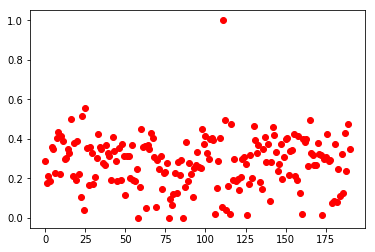

In [30]:
# Visualize the similarity values wrt NY
plt.figure
plt.plot(cs_similarity[111,:],'ro')

# Search for similarity values greater than 0.5 and identify the city
print('Indices of cities with similarity > 0.5: ',np.where(cs_similarity[111,:]>=0.5))


In [31]:
# Print the cities having higher similarity distance with NY
city_grouped.iloc[[ 23,  25,  111]]

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Rec Center,College Residence Hall,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New 

This concludes our data analysis. The final report is documented along with this notebook. 